In [112]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json
import torch 
import torch.nn as nn
import os
from PIL import Image, ImageDraw
import numpy as np
from matplotlib.patches import Polygon
import torch.optim as optim
import torchvision.transforms as transforms
import albumentations as A
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import random 
import matplotlib.patches as patches
import skimage.draw 
import tifffile 
import shutil

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# cristian path 
base_dir = '/home/csalitre/school/ecgr-5106/final-project/' 


In [113]:
file_path_train = base_dir + '/semantic-segmentation/data/train/_annotations.coco.json'
file_path_valid = base_dir + '/semantic-segmentation/data/valid/_annotations.coco.json'   
file_paht_test = base_dir + '/semantic-segmentation/data/test/_annotations.coco.json'

# Doc file JSON
with open(file_path_train, 'r') as file:
    data_train = json.load(file)

with open(file_path_valid, 'r') as file:
    data_valid = json.load(file)

with open(file_paht_test, 'r') as file:
    data_test = json.load(file) 

for img in data_train['images'][:10]:
    print(img['file_name'])

data_train['categories']

2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg
2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg
2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg
2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg
2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg
2161_jpg.rf.3be4125d1ffe011c0ed462d9fe0d2152.jpg
2265_jpg.rf.3c62c7b8825039fab853256f9a9fe141.jpg
1491_jpg.rf.3c658e83538de0fa5a3f4e13d7d85f12.jpg
1385_jpg.rf.3c67cb92e2922dba0e6dba86f69df40b.jpg
2534_jpg.rf.3c8c86666860368d46b8f7bcd95ac220.jpg


[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]

In [114]:
def draw_mask(img_names, data):
    fig, ax = plt.subplots(2, 2, figsize=(15, 15))

    for i, img_name in enumerate(img_names):
        img = cv2.imread(img_name)
        img_filename = os.path.basename(img_name)
        img_id = [item for item in data['images'] if item['file_name'] == img_filename][0]['id']
        img_mask = [mask for mask in data['annotations'] if mask['image_id'] == img_id]
        points_list = img_mask[0]['segmentation']
        points = np.array(points_list, np.int32)
        points = points.reshape((-1, 1, 2))

        cv2.polylines(img, [points], True,(0, 0, 255), 3)

        ax[i//2, i%2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[i//2, i%2].axis('off')
    plt.show()


In [115]:
# Load train images
img_train_dir = base_dir + '/semantic-segmentation/data/train/'
all_train_img_files = [os.path.join(img_train_dir, img['file_name']) for img in data_train['images']]

# Load valid images
img_valid_dir = base_dir + '/semantic-segmentation/data/valid/'
all_valid_img_files = [os.path.join(img_valid_dir, img['file_name']) for img in data_valid['images']]

# Load test images
img_test_dir = base_dir + '/semantic-segmentation/data/test/'
all_test_img_files = [os.path.join(img_test_dir, img['file_name']) for img in data_test['images']]
                      

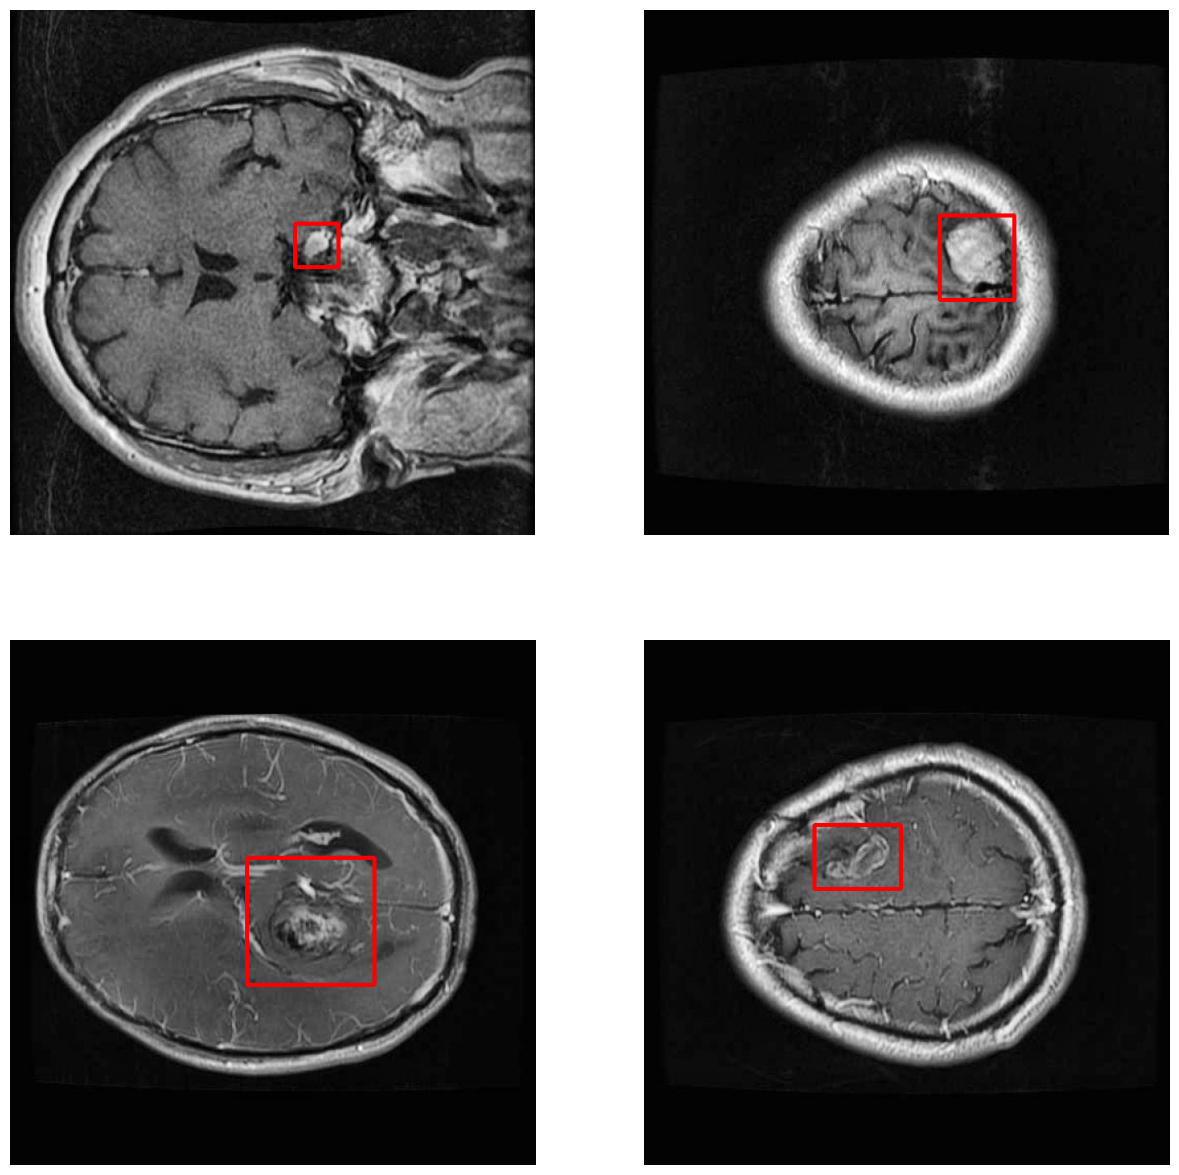

In [116]:
# plot random masked image
random_file = random.sample(all_train_img_files, 4)
draw_mask(random_file, data_train)

In [117]:
def create_mask(image_info, annotations, output_folder, max_print=3):
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    obj_number = 1
    printed_masks = 0 
    
    for ann in annotations:
        if image_info['id'] == ann['image_id']:
            for seg_idx, seg in enumerate(ann['segmentation']):
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                seg_mask = np.zeros(mask_np.shape, dtype=np.uint8)
                seg_mask[rr, cc] = 255
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
                printed_masks += 1
                if printed_masks >= max_print:
                    return  # Exit the function if we have printed the maximum number of masks 


def main(json_file,mask_output_folder,image_output_folder,original_image_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)
        
    images = data['images']
    annotations = data['annotations']

     # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)
        
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        
        ## learn how to op
        shutil.copy2(original_image_path, new_image_path)

In [118]:
# seperate original images and masks
original_image_dir = base_dir + '/semantic-segmentation/data/train/'
json_file = base_dir + '/semantic-segmentation/data/train/_annotations.coco.json'
mask_output_folder = '../train2/masks'
image_output_folder = '../train2/images'
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = base_dir + '/semantic-segmentation/data/valid/'
json_file = base_dir + '/semantic-segmentation/data/valid/_annotations.coco.json'  
mask_output_folder = '../valid2/masks'
image_output_folder = '../valid2/images'
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = base_dir + '/semantic-segmentation/data/test/'
json_file = base_dir + '/semantic-segmentation/data/test/_annotations.coco.json'
mask_output_folder = '../test2/masks'
image_output_folder = '../test2/images'
main(json_file, mask_output_folder, image_output_folder, original_image_dir)


In [119]:
def compare_folders(folder1, folder2, folder3):
    for folder_path in [folder1, folder2, folder3]:
        folder_items = os.listdir(folder_path)
        other_folders = [f for f in [folder1, folder2, folder3] if f != folder_path]
        for item in folder_items:
            corresponding_found = False
            for other_folder in other_folders:
                if any(item[:4] == o[:4] for o in os.listdir(other_folder)):
                    corresponding_found = True
                    break
            if not corresponding_found:
                print(f"Corresponding item for {item} not found in other folders.")
                item_path = os.path.join(folder_path, item)
                os.remove(item_path)
                print(f"Deleted {item}")

folder1_path = os.path.join(base_dir, 'semantic-segmentation/data/train')
folder2_path = os.path.join(base_dir, 'semantic-segmentation/data/valid')
folder3_path = os.path.join(base_dir, 'semantic-segmentation/data/test')

# Delete original images
#compare_folders(folder1_path, folder2_path, folder3_path)


In [120]:
class MatchDataset:
    def __init__(self,root_dir):
        self.root = root_dir
        self.image_f = os.path.join(root_dir,'images')
        self.mask_f = os.path.join(root_dir,'masks')
        self.images = sorted(os.listdir(self.image_f))
        self.masks = sorted(os.listdir(self.mask_f))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        img_name = self.images[index]
        mask_name = self.masks[index]
        img_path = os.path.join(self.image_f,img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        mask_path = os.path.join(self.mask_f,mask_name)
        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        
        return img,mask

dataset = MatchDataset(base_dir + 'semantic-segmentation/train2/')
img,mask = dataset[0]
img.shape,mask.shape

((640, 640, 3), (640, 640))

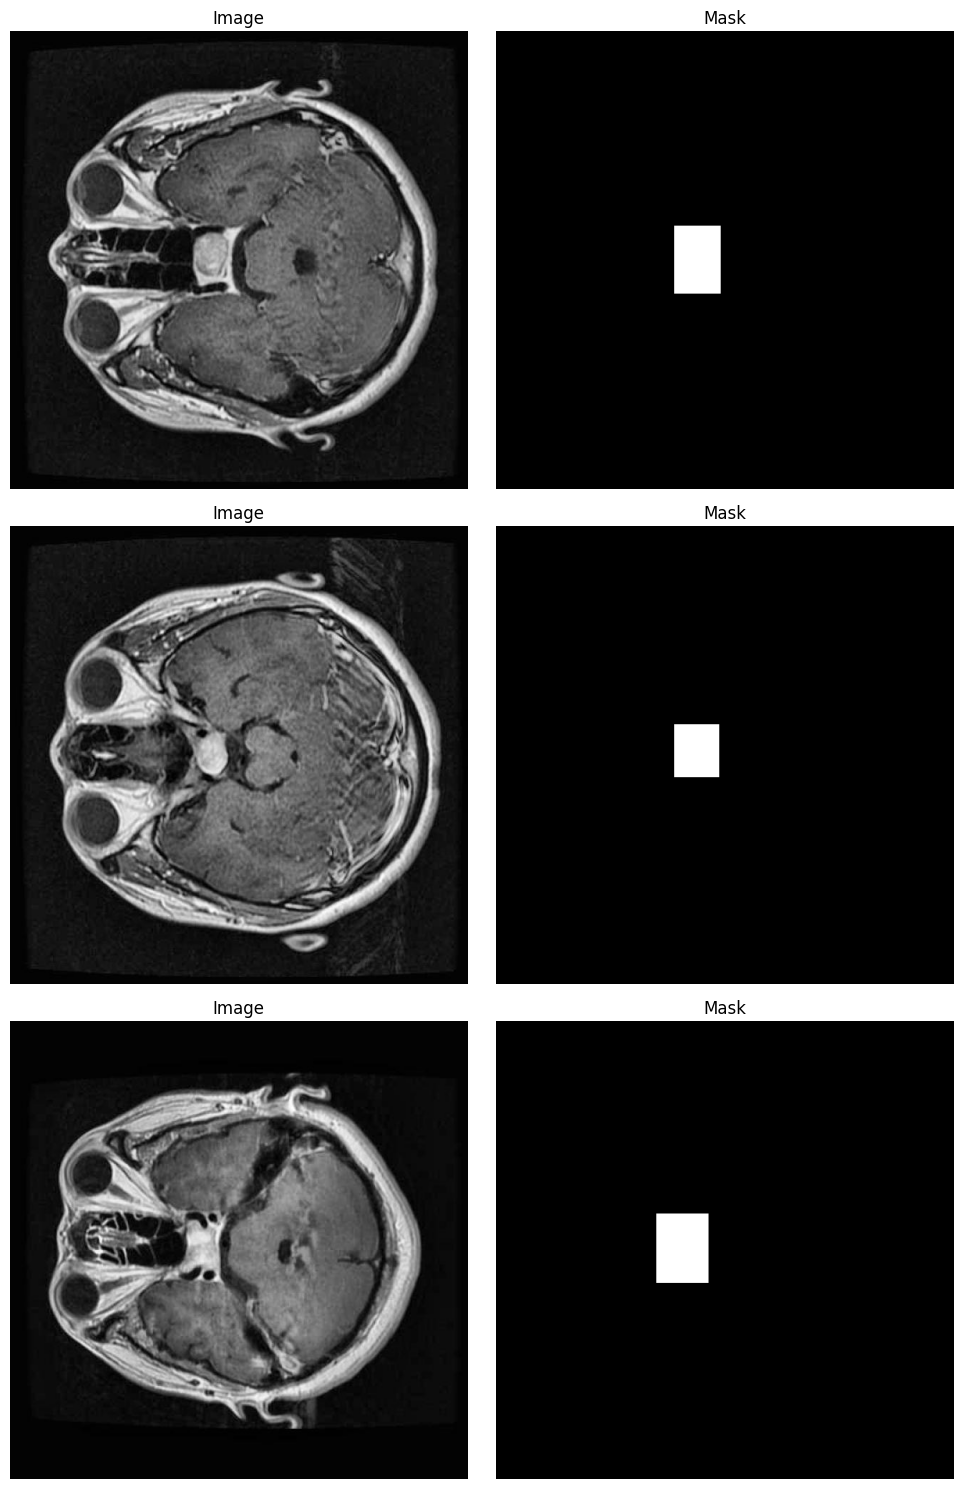

In [121]:
fig,axs = plt.subplots(3,2,figsize=(10,15))
for i in range(3):  # Plot the first three samples
    image, mask = dataset[i]
    axs[i, 0].imshow(image)
    axs[i, 0].set_title('Image')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title('Mask')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [138]:
class BrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

        # Print lengths of image_files and mask_files for debugging
        print(f"Length of image files: {len(self.image_files)}")
        print(f"Length of mask files: {len(self.mask_files)}")

     # Check consistency of image and mask files
        if len(self.image_files) != len(self.mask_files):
            mismatched_file_index = len(self.image_files) if len(self.image_files) < len(self.mask_files) else len(self.mask_files)
            print(f"Mismatched files: {self.image_files[mismatched_file_index]}")
            raise ValueError("Number of images and masks do not match.")
    
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self,idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L")  # Convert to grayscale
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)
        return image_gray, mask


In [181]:
train_path = base_dir + 'semantic-segmentation/train2/' 
valid_path = base_dir + 'semantic-segmentation/valid2/'
test_path = base_dir + 'semantic-segmentation/test2/'

image_transform = transforms.Compose([
    transforms.Resize(650),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

In [162]:
import os

def find_mismatched_files(image_folder, mask_folder):
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))
    
    mismatched_files = []
    for image_file, mask_file in zip(image_files, mask_files):
        image_number = int(image_file.split('_')[0])
        mask_number = int(mask_file.split('_')[0])
        print(image_number, mask_number)
        if image_number != mask_number:
            mismatched_files.append((image_file, mask_file))
    
    return mismatched_files

# Example usage:
image_folder = base_dir + 'semantic-segmentation/train2/images'
mask_folder = base_dir + 'semantic-segmentation/train2/masks'
mismatched_files = find_mismatched_files(image_folder, mask_folder)

if mismatched_files:
    print("Mismatched files:")
    for image_file, mask_file in mismatched_files:
        print(f"Image: {image_file}, Mask: {mask_file}")
else:
    print("No mismatched files.")


1000 1000
1002 1002
1003 1003
1004 1004
1005 1005
1008 1008
100 100
1010 1010
1012 1012
1013 1013
1014 1014
1015 1015
1016 1016
1019 1019
1020 1020
1025 1025
1026 1026
1027 1027
1028 1028
1029 1029
102 102
1031 1031
1032 1032
1034 1034
1037 1037
1038 1038
1039 1039
103 103
1040 1040
1042 1042
1043 1043
1044 1044
1046 1046
1047 1047
1049 1049
104 104
1050 1050
1053 1053
1054 1054
1055 1055
1059 1059
105 105
1060 1060
1062 1062
1063 1063
1067 1067
1068 1068
1069 1069
106 106
1073 1073
1074 1074
1076 1076
1077 1077
1078 1078
1079 1079
1080 1080
1081 1081
1084 1084
1085 1085
1086 1086
1087 1087
1088 1088
108 108
1090 1090
1091 1091
1092 1092
1094 1094
1095 1095
1096 1096
1098 1098
1099 1099
109 109
10 10
1100 1100
1101 1101
1102 1102
1104 1104
1105 1105
1106 1106
1107 1107
1108 1108
1109 1109
110 110
1111 1111
1112 1112
1113 1113
1114 1114
1116 1116
1117 1117
1118 1118
111 111
1120 1120
1121 1121
1123 1123
1124 1124
1127 1127
1128 1128
1129 1129
112 112
1131 1131
1132 1132
1133 1133
1134 1

In [163]:
train_dataset = BrainDataset(train_path, transform=image_transform)
valid_dataset = BrainDataset(valid_path, transform=image_transform)
test_dataset = BrainDataset(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Length of image files: 1501
Length of mask files: 1501
Length of image files: 429
Length of mask files: 429
Length of image files: 215
Length of mask files: 215


In [164]:

from collections import OrderedDict

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=16):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 2, features * 4, name="bottleneck")

        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        bottleneck = self.bottleneck(self.pool2(enc2))

        dec2 = self.upconv2(bottleneck)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


In [180]:

def train(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    """
    Trains a model using the given dataloaders.

    Args:
        model: The model to train.
        criterion: The loss function.
        optimizer: The optimizer to use.
        train_loader: The training dataloader.
        val_loader: The validation dataloader.
        num_epochs: The number of epochs to train for.
    """
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            masks = masks.float()
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
                running_loss = 0.0

        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                outputs = torch.sigmoid(outputs)
                #print(outputs.shape)
                #print(outputs.argmax(1))
                predicted = (outputs > 0.5).float()
                total += masks.numel()
                correct += (predicted == masks).sum().item()

        print(f"Epoch {epoch + 1}, validation accuracy: {100 * correct / total:.2f}%")

# Iterate over the data loader
for inputs, _ in train_loader:
    print("Input size:", inputs.shape)
    break 


Input size: torch.Size([16, 1, 224, 224])


In [182]:
# Training Pipeline
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
num_epochs = 10



train(model, criterion, optimizer, train_loader, valid_loader, num_epochs)


Epoch 1, validation accuracy: 3.60%
Epoch 2, validation accuracy: 3.60%
Epoch 3, validation accuracy: 3.60%
Epoch 4, validation accuracy: 3.60%
Epoch 5, validation accuracy: 3.60%
Epoch 6, validation accuracy: 3.60%
Epoch 7, validation accuracy: 3.60%
Epoch 8, validation accuracy: 3.60%
Epoch 9, validation accuracy: 3.60%
Epoch 10, validation accuracy: 3.60%


In [191]:
# Save the model 
torch.save(model.state_dict(), base_dir + 'semantic-segmentation/model.pth')



In [196]:

model.load_state_dict(torch.load(base_dir + 'semantic-segmentation/model.pth'))
model.eval()


image = Image.open(base_dir + 'semantic-segmentation/test2/images/142_jpg.rf.6e227599721aa3921ac5bc0f57153f6f.jpg')
transform = transforms.Compose([
    transforms.Resize(650),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
])

input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor).to(device)

predicted_mask = output.squeeze().cpu().numpy()
plt.imshow(predicted_mask, cmap='gray')
plt.show()



RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 324 but got size 325 for tensor number 1 in the list.